In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 90
        self.filters = 16
        self.joint_ind = np.array([0,1,2,5,6,9,10,13,14,17,18,21])
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/SHREC/'
C = Config()

In [4]:
from scipy.spatial.distance import cdist
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,0,C.joint_n+1)
    for f in range(C.frame_l):
        #distance max 
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M)   
    return M

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=12,joint_d=3,feat_d=90,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = block(M,filters)
    x = MaxPool1D(2)(x)
    
    x_d_slow = block(diff_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    
    x_d_fast = block(diff_fast,filters)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


In [6]:
def build_AR_single(frame_l=32,joint_n=22,joint_d=3,feat_d=90,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [7]:
AR_single = build_AR_single(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)

In [8]:
AR_single.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 90)       0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 12, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 128)       112096      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           model_1[1][0]                    
__________

In [9]:
AR_single.load_weights('weights/coarse_lite.h5')

## load data

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

## Without frame_sampling train

In [12]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|          | 17/1960 [00:00<00:11, 164.36it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 1960/1960 [00:05<00:00, 389.86it/s]


In [13]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

  5%|▌         | 42/840 [00:00<00:01, 413.01it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 840/840 [00:02<00:00, 413.63it/s]


In [19]:
len(Y_test)/276

3.0434782608695654

In [41]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=2e-5)
history = AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=300,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 1960 samples, validate on 840 samples
Epoch 1/300
1960/1960 [==============================] - 5s 3ms/step - loss: 0.0256 - acc: 0.9974 - val_loss: 0.3908 - val_acc: 0.9107
Epoch 2/300
1960/1960 [==============================] - 0s 49us/step - loss: 0.0212 - acc: 0.9985 - val_loss: 0.3903 - val_acc: 0.9119
Epoch 3/300
1960/1960 [==============================] - 0s 45us/step - loss: 0.0301 - acc: 0.9964 - val_loss: 0.3900 - val_acc: 0.9119
Epoch 4/300
1960/1960 [==============================] - 0s 49us/step - loss: 0.0307 - acc: 0.9944 - val_loss: 0.3899 - val_acc: 0.9119
Epoch 5/300
1960/1960 [==============================] - 0s 53us/step - loss: 0.0264 - acc: 0.9980 - val_loss: 0.3899 - val_acc: 0.9119
Epoch 6/300
1960/1960 [==============================] - 0s 53us/step - loss: 0.0333 - acc: 0.9934 - val_loss: 0.3903 - val_acc: 0.9107
Epoch 7/300
1960/1960 [==============================] - 0s 54us/step - loss: 0.0275 - acc: 0.9954 - val_loss: 0.3907 - val_acc: 0.9107
Ep

Epoch 61/300
1960/1960 [==============================] - 0s 57us/step - loss: 0.0296 - acc: 0.9949 - val_loss: 0.3906 - val_acc: 0.9107
Epoch 62/300
1960/1960 [==============================] - 0s 47us/step - loss: 0.0303 - acc: 0.9954 - val_loss: 0.3907 - val_acc: 0.9107
Epoch 63/300
1960/1960 [==============================] - 0s 55us/step - loss: 0.0258 - acc: 0.9964 - val_loss: 0.3909 - val_acc: 0.9107
Epoch 64/300
1960/1960 [==============================] - 0s 48us/step - loss: 0.0242 - acc: 0.9974 - val_loss: 0.3910 - val_acc: 0.9107
Epoch 65/300
1960/1960 [==============================] - 0s 59us/step - loss: 0.0261 - acc: 0.9959 - val_loss: 0.3913 - val_acc: 0.9107
Epoch 66/300
1960/1960 [==============================] - 0s 56us/step - loss: 0.0267 - acc: 0.9949 - val_loss: 0.3915 - val_acc: 0.9107
Epoch 67/300
1960/1960 [==============================] - 0s 54us/step - loss: 0.0344 - acc: 0.9929 - val_loss: 0.3918 - val_acc: 0.9107
Epoch 68/300
1960/1960 [=================

Epoch 121/300
1960/1960 [==============================] - 0s 45us/step - loss: 0.0217 - acc: 0.9969 - val_loss: 0.3951 - val_acc: 0.9095
Epoch 122/300
1960/1960 [==============================] - 0s 44us/step - loss: 0.0256 - acc: 0.9974 - val_loss: 0.3952 - val_acc: 0.9095
Epoch 123/300
1960/1960 [==============================] - 0s 49us/step - loss: 0.0247 - acc: 0.9969 - val_loss: 0.3953 - val_acc: 0.9095
Epoch 124/300
1960/1960 [==============================] - 0s 45us/step - loss: 0.0257 - acc: 0.9954 - val_loss: 0.3953 - val_acc: 0.9095
Epoch 125/300
1960/1960 [==============================] - 0s 41us/step - loss: 0.0296 - acc: 0.9939 - val_loss: 0.3954 - val_acc: 0.9095
Epoch 126/300
1960/1960 [==============================] - 0s 40us/step - loss: 0.0220 - acc: 0.9974 - val_loss: 0.3954 - val_acc: 0.9095
Epoch 127/300
1960/1960 [==============================] - 0s 41us/step - loss: 0.0328 - acc: 0.9944 - val_loss: 0.3954 - val_acc: 0.9095
Epoch 128/300
1960/1960 [=========

Epoch 181/300
1960/1960 [==============================] - 0s 49us/step - loss: 0.0229 - acc: 0.9974 - val_loss: 0.3919 - val_acc: 0.9083
Epoch 182/300
1960/1960 [==============================] - 0s 42us/step - loss: 0.0250 - acc: 0.9959 - val_loss: 0.3919 - val_acc: 0.9083
Epoch 183/300
1960/1960 [==============================] - 0s 44us/step - loss: 0.0250 - acc: 0.9954 - val_loss: 0.3919 - val_acc: 0.9083
Epoch 184/300
1960/1960 [==============================] - 0s 43us/step - loss: 0.0261 - acc: 0.9969 - val_loss: 0.3918 - val_acc: 0.9083
Epoch 185/300
1960/1960 [==============================] - 0s 55us/step - loss: 0.0269 - acc: 0.9949 - val_loss: 0.3918 - val_acc: 0.9083
Epoch 186/300
1960/1960 [==============================] - 0s 50us/step - loss: 0.0202 - acc: 0.9995 - val_loss: 0.3919 - val_acc: 0.9083
Epoch 187/300
1960/1960 [==============================] - 0s 43us/step - loss: 0.0244 - acc: 0.9980 - val_loss: 0.3919 - val_acc: 0.9083
Epoch 188/300
1960/1960 [=========

Epoch 241/300
1960/1960 [==============================] - 0s 45us/step - loss: 0.0221 - acc: 0.9974 - val_loss: 0.3978 - val_acc: 0.9107
Epoch 242/300
1960/1960 [==============================] - 0s 43us/step - loss: 0.0271 - acc: 0.9959 - val_loss: 0.3979 - val_acc: 0.9107
Epoch 243/300
1960/1960 [==============================] - 0s 42us/step - loss: 0.0247 - acc: 0.9939 - val_loss: 0.3979 - val_acc: 0.9107
Epoch 244/300
1960/1960 [==============================] - 0s 42us/step - loss: 0.0265 - acc: 0.9949 - val_loss: 0.3979 - val_acc: 0.9107
Epoch 245/300
1960/1960 [==============================] - 0s 43us/step - loss: 0.0251 - acc: 0.9959 - val_loss: 0.3979 - val_acc: 0.9107
Epoch 246/300
1960/1960 [==============================] - 0s 41us/step - loss: 0.0269 - acc: 0.9969 - val_loss: 0.3979 - val_acc: 0.9107
Epoch 247/300
1960/1960 [==============================] - 0s 50us/step - loss: 0.0220 - acc: 0.9974 - val_loss: 0.3978 - val_acc: 0.9107
Epoch 248/300
1960/1960 [=========

In [9]:
AR_single.save_weights('weights/coarse_lite.h5')

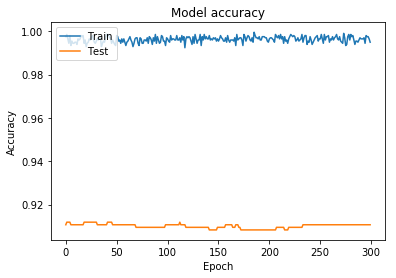

In [43]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## With frame_sampling

In [21]:
def sampling_frame(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]    
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

In [44]:
lr = 1e-5
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [45]:
epochs = 50
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    #for i in tqdm(range(len(Train['pose']))): 
    for i in range(len(Train['pose'])): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
        p = sampling_frame(p,C)
        
        #rotation
        x_angle = np.random.uniform(-0.2,0.2)
        y_angle = np.random.uniform(-0.2,0.2)
        z_angle = np.random.uniform(-0.2,0.2)
        R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
        p = rotaion_one(p,R)
        
        p = normlize_range(p)
  
        p[:,:,0] = p[:,:,0]*random.uniform(0.9, 1.1)+p[:,:,0]*random.uniform(-0.1,0.1)
        p[:,:,1] = p[:,:,1]*random.uniform(0.9, 1.1)+p[:,:,1]*random.uniform(-0.1,0.1)
        p[:,:,2] = p[:,:,2]*random.uniform(0.9, 1.1)+p[:,:,2]*random.uniform(-0.1,0.1)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    AR_single.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

    if e%10==0:
        AR_single.save_weights('weights/coarse_lite_aug.h5')

epoch0


/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 6s 3ms/step - loss: 0.0866 - acc: 0.9796 - val_loss: 0.3958 - val_acc: 0.9107
epoch1
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 42us/step - loss: 0.0959 - acc: 0.9765 - val_loss: 0.3958 - val_acc: 0.9119
epoch2
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 39us/step - loss: 0.0954 - acc: 0.9765 - val_loss: 0.3958 - val_acc: 0.9119
epoch3
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 43us/step - loss: 0.0949 - acc: 0.9776 - val_loss: 0.3960 - val_acc: 0.9119
epoch4
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 47us/step - loss: 0.0877 - acc: 0.9765 - val_loss: 0.3963 - val_acc: 0.9119
epoch5
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960

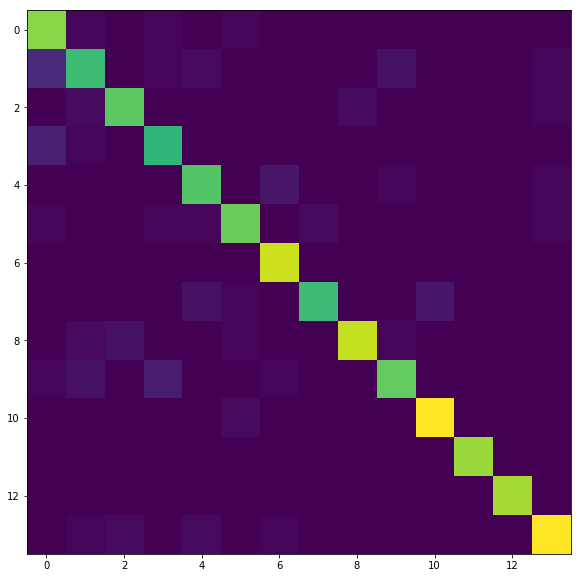

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = AR_single.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()